# Customer Churn Prediction for a Telecom Company

![Customer Churn Cover](https://i.ibb.co/FqcwHcWC/customer-churn.jpg)

# 1. Importing Libraries

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio

import warnings
warnings.filterwarnings("ignore")

# 2. Loading Dataset

In [2]:
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
pd.set_option('display.max_columns', None)
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# 3. Exploring Data

In [3]:
print('Dataset shape:', data.shape)

Dataset shape: (7043, 21)


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
null_values = data.isna().sum()
print("Null Values Per Column:\n", null_values)

Null Values Per Column:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [6]:
duplicate_values = data.duplicated().sum()
print("Duplicate Values:", duplicate_values)

Duplicate Values: 0


In [7]:
data['gender'].value_counts()

gender
Male      3555
Female    3488
Name: count, dtype: int64

In [8]:
data['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [9]:
data['tenure'].value_counts().head()

tenure
1     613
72    362
2     238
3     200
4     176
Name: count, dtype: int64

# 4. Visualization

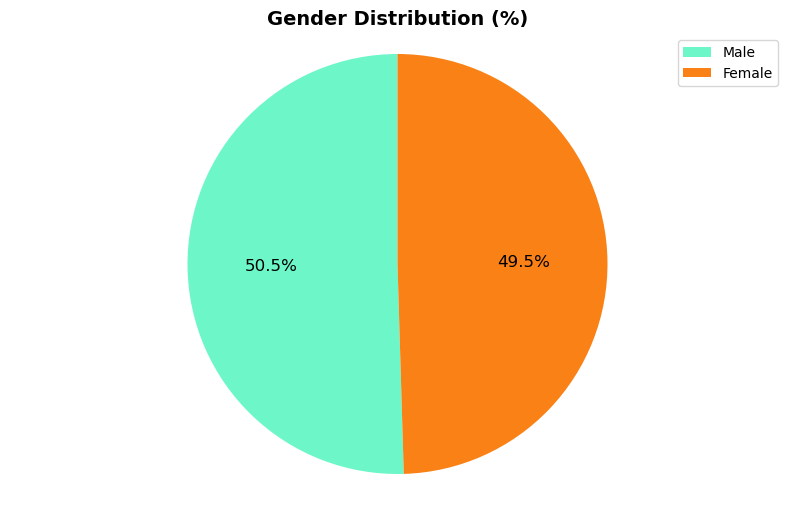

In [10]:
# Count gender values
gender_counts = data['gender'].value_counts()
labels = gender_counts.index
sizes = gender_counts.values

# Plot pie chart
plt.figure(figsize=(10, 6))
plt.pie(sizes, autopct='%1.1f%%', startangle=90, colors=['#6df7c9','#fa8116'], textprops={'fontsize': 12})
plt.title('Gender Distribution (%)', fontsize=14, fontweight='bold')
plt.axis('equal')  # Keep circle shape
plt.legend(labels=['Male', 'Female'])
plt.savefig('gender_distribution.png', bbox_inches='tight', dpi = 300)
plt.show()

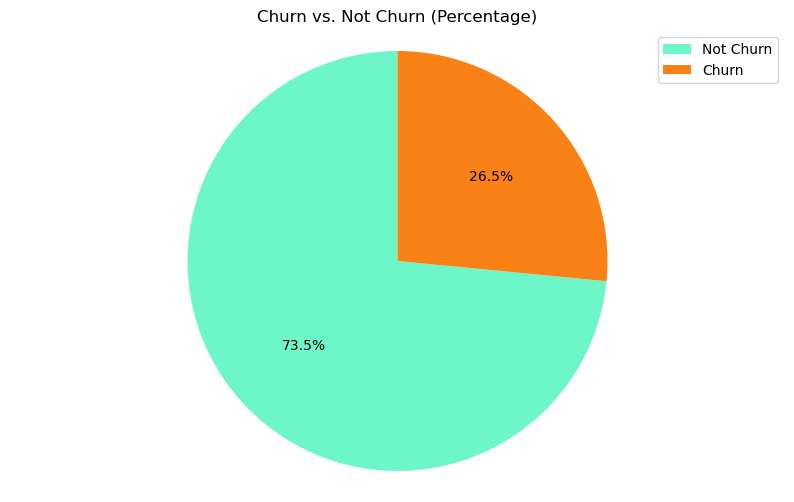

In [11]:
# Count values
churn_counts = data['Churn'].value_counts()
labels = churn_counts.index
sizes = churn_counts.values
percentages = churn_counts.values / churn_counts.values.sum() * 100

# Plot pie chart
plt.figure(figsize=(10, 6))
plt.pie(sizes, autopct='%1.1f%%', startangle=90, colors=['#6df7c9','#fa8116'])
plt.title('Churn vs. Not Churn (Percentage)')
plt.axis('equal')  # Equal aspect ratio ensures pie is a circle
plt.legend(labels=['Not Churn', 'Churn'])
plt.savefig('Churn vs Not Churn.png', bbox_inches='tight', dpi = 300)
plt.show()

In [12]:
# Force compatible renderer
#pio.renderers.default = 'iframe_connected'

# Clean up strings
data['gender'] = data['gender'].str.strip().str.title()
data['Churn'] = data['Churn'].str.strip().str.title()

# Sunburst with custom center (Gender) colors
fig = px.sunburst(
    data,
    path=['gender', 'Churn'],  # hierarchy
    values=None,               # auto-count
    color='gender',            # set color by central node
    color_discrete_map={
        'Male': "#57b6fa",     # custom blue
        'Female': '#e377c2'    # custom pink
    },
    title='Customer Churn Breakdown by Gender'
)

fig.update_traces(textinfo='label+percent entry')
fig.show()


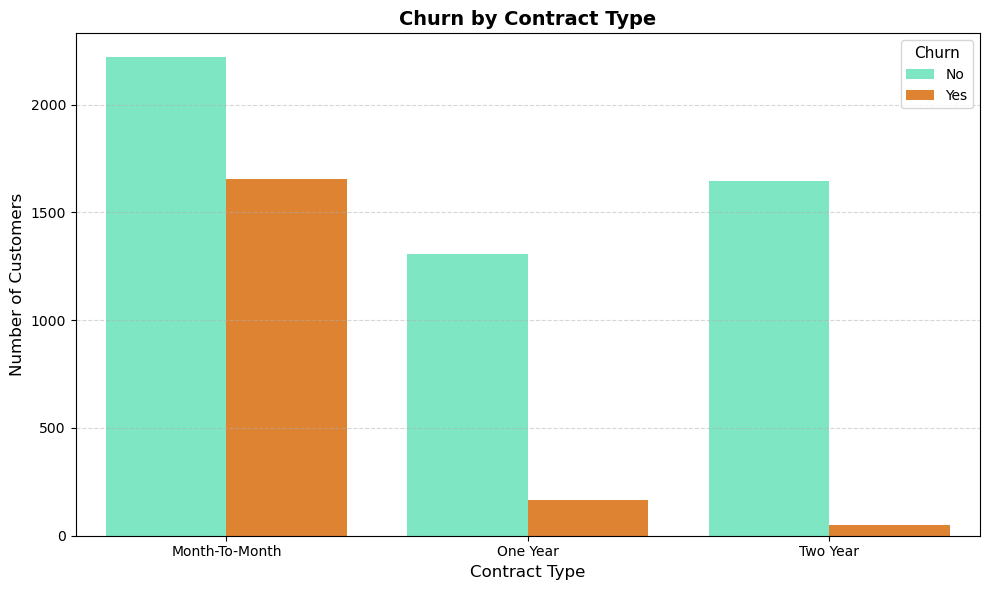

In [13]:
# Clean up strings
data['Churn'] = data['Churn'].str.strip().str.title()
data['Contract'] = data['Contract'].str.strip().str.title()

plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Contract', hue='Churn', palette=['#6df7c9', '#fa8116'])

plt.title('Churn by Contract Type', fontsize=14, fontweight='bold')
plt.xlabel('Contract Type', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.legend(title='Churn', title_fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('churn_by_contract.png', bbox_inches='tight', dpi = 300)
plt.show()

In [14]:
# Force compatible renderer
#pio.renderers.default = 'iframe_connected'

# Clean up strings
data['Churn'] = data['Churn'].str.strip().str.title()
data['PaymentMethod'] = data['PaymentMethod'].str.strip().str.title()

# Create sunburst chart
fig = px.sunburst(
    data,
    path=['Churn', 'PaymentMethod'],  # hierarchy: Churn → Payment Method
    values=None,                      # auto-counts rows
    color='Churn',                    # color by churn status
    color_discrete_map={
        'Yes': '#fa8116',    # Churned
        'No': '#6df7c9'      # Not churned
    },
    title='Churn Breakdown by Payment Method'
)

# Show label + percentage per entry
fig.update_traces(textinfo='label+percent entry')
fig.show()

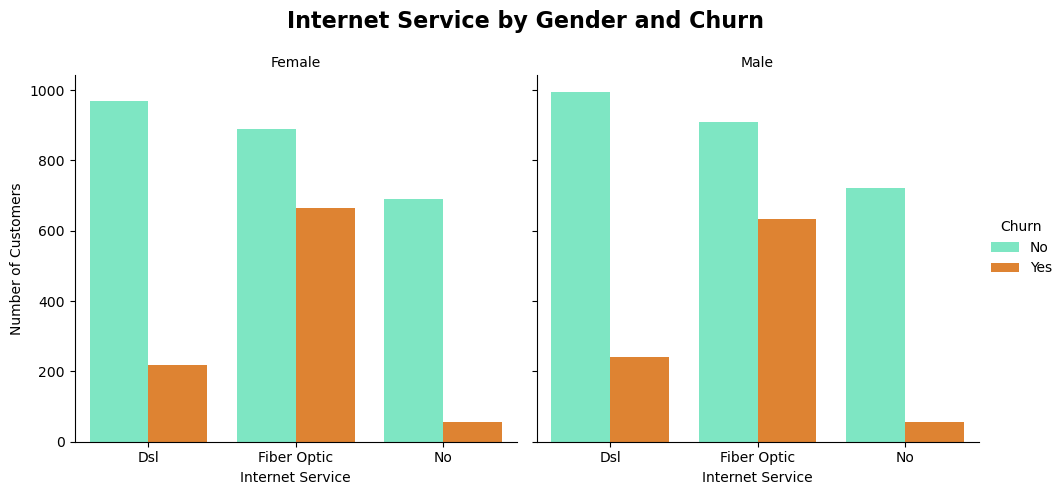

In [15]:
# Clean up columns
data['gender'] = data['gender'].str.strip().str.title()
data['Churn'] = data['Churn'].str.strip().str.title()
data['InternetService'] = data['InternetService'].str.strip().str.title()

# Plot grouped bar chart
g = sns.catplot(
    data=data,
    x='InternetService',
    hue='Churn',
    col='gender',
    kind='count',
    palette=['#6df7c9', '#fa8116'],  # Not churned, Churned
    height=5,
    aspect=1
)

g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Internet Service by Gender and Churn', fontsize=16, fontweight='bold')
g.set_axis_labels("Internet Service", "Number of Customers")
g.set_titles("{col_name}")
plt.savefig('internet_service.png', bbox_inches='tight', dpi = 300)
plt.show()


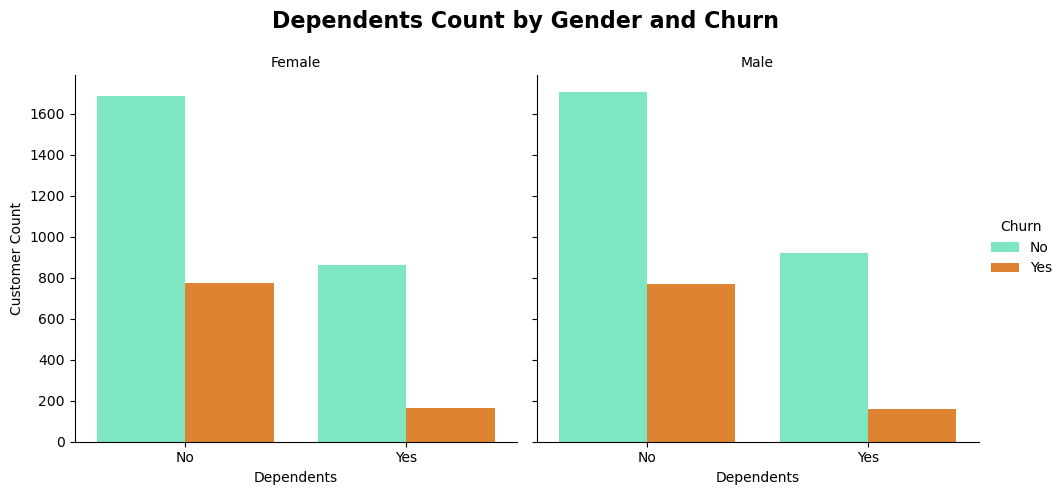

In [16]:
# Clean up values
data['Dependents'] = data['Dependents'].str.strip().str.title()
data['gender'] = data['gender'].str.strip().str.title()
data['Churn'] = data['Churn'].str.strip().str.title()

# Create grouped bar chart
g = sns.catplot(
    data=data,
    x='Dependents',
    hue='Churn',
    col='gender',
    kind='count',
    palette={'No': '#6df7c9', 'Yes': '#fa8116'},
    height=5,
    aspect=1
)

# Add custom titles and formatting
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Dependents Count by Gender and Churn', fontsize=16, fontweight='bold')
g.set_axis_labels("Dependents", "Customer Count")
g.set_titles("{col_name}")  # sets the column header to the gender
plt.savefig('dependents.png', bbox_inches='tight', dpi = 300)
plt.show()

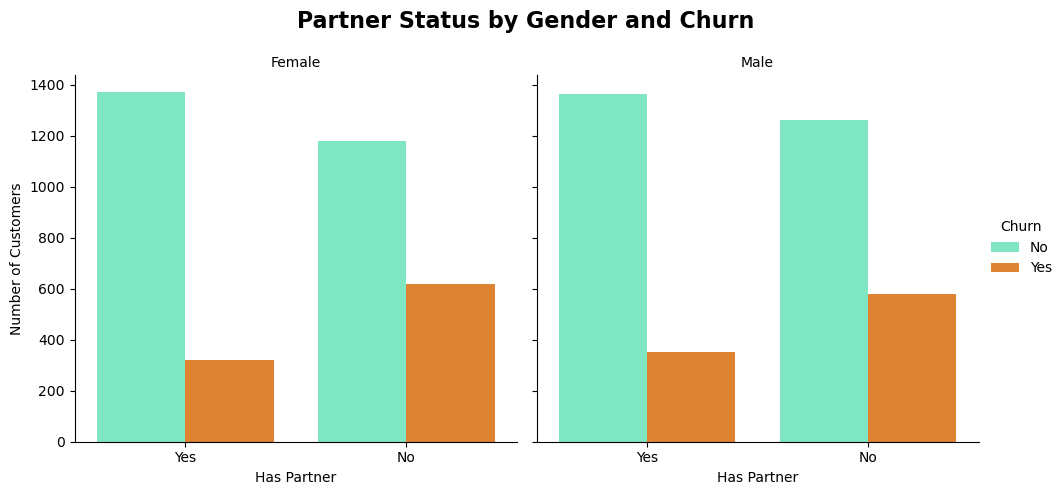

In [17]:
# Clean up values
data['Partner'] = data['Partner'].str.strip().str.title()
data['gender'] = data['gender'].str.strip().str.title()
data['Churn'] = data['Churn'].str.strip().str.title()

# Plot grouped bar chart
g = sns.catplot(
    data=data,
    x='Partner',
    hue='Churn',
    col='gender',
    kind='count',
    palette={'No': '#6df7c9', 'Yes': '#fa8116'},  # Not Churned, Churned
    height=5,
    aspect=1
)

# Customize titles and labels
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Partner Status by Gender and Churn', fontsize=16, fontweight='bold')
g.set_axis_labels("Has Partner", "Number of Customers")
g.set_titles("{col_name}")  # Gender titles
plt.savefig('partner.png', bbox_inches='tight', dpi = 300)
plt.show()

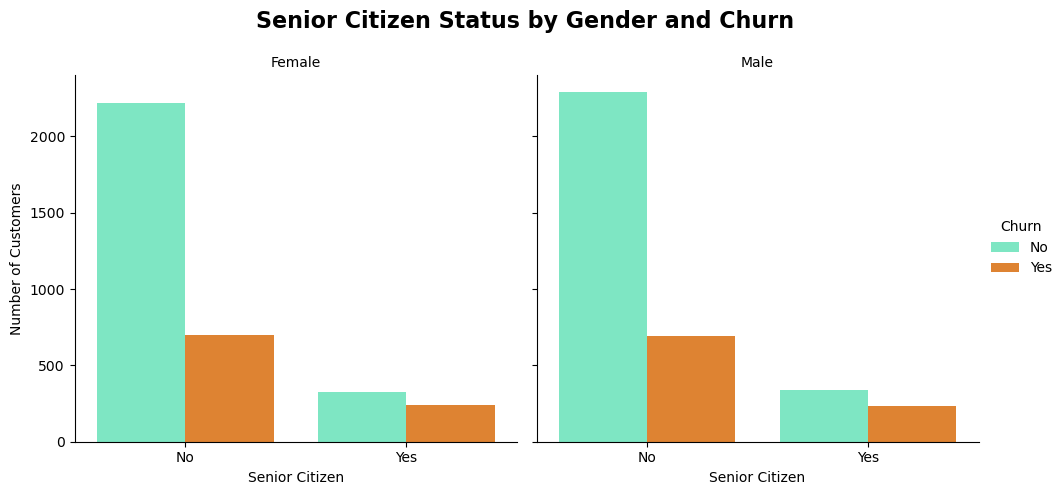

In [18]:
# Map SeniorCitizen from 0/1 to 'No'/'Yes' for clarity
data['SeniorCitizen'] = data['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

# Clean other values
data['gender'] = data['gender'].str.strip().str.title()
data['Churn'] = data['Churn'].str.strip().str.title()

# Plot
g = sns.catplot(
    data=data,
    x='SeniorCitizen',
    hue='Churn',
    col='gender',
    kind='count',
    palette={'No': '#6df7c9', 'Yes': '#fa8116'},  # Not Churned, Churned
    height=5,
    aspect=1
)

# Customize labels and titles
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Senior Citizen Status by Gender and Churn', fontsize=16, fontweight='bold')
g.set_axis_labels("Senior Citizen", "Number of Customers")
g.set_titles("{col_name}")  # Shows 'Male' / 'Female'
plt.savefig('senior.png', bbox_inches='tight', dpi = 300)
plt.show()

# 5. Feature Engineering

In [19]:
# Create Tenure Buckets
def bucket_tenure(tenure):
    if tenure <= 12:
        return '0-1 year'
    elif tenure <= 24:
        return '1-2 years'
    elif tenure <= 48:
        return '2-4 years'
    else:
        return '4+ years'

data['TenureBucket'] = data['tenure'].apply(bucket_tenure)

In [20]:
data['TenureBucket'].value_counts()

TenureBucket
4+ years     2239
0-1 year     2186
2-4 years    1594
1-2 years    1024
Name: count, dtype: int64

In [21]:
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'TenureBucket'],
      dtype='object')

In [22]:
# Label Encoding
columns_to_encode = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'Churn',
       'TenureBucket'] 

le = LabelEncoder()
for column in columns_to_encode:
    data[column] = le.fit_transform(data[column])

In [23]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TenureBucket
0,7590-VHVEG,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0,0
1,5575-GNVDE,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.5,0,2
2,3668-QPYBK,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1,0
3,7795-CFOCW,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0,2
4,9237-HQITU,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1,0


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   int64  
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   int64  
 4   Dependents        7043 non-null   int64  
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   int64  
 7   MultipleLines     7043 non-null   int64  
 8   InternetService   7043 non-null   int64  
 9   OnlineSecurity    7043 non-null   int64  
 10  OnlineBackup      7043 non-null   int64  
 11  DeviceProtection  7043 non-null   int64  
 12  TechSupport       7043 non-null   int64  
 13  StreamingTV       7043 non-null   int64  
 14  StreamingMovies   7043 non-null   int64  
 15  Contract          7043 non-null   int64  
 16  PaperlessBilling  7043 non-null   int64  


##### Datatype of column TotalCharges is object. We need to convert it to float.

In [25]:
data['TotalCharges'].value_counts().head()

TotalCharges
20.2     11
         11
19.75     9
19.65     8
19.9      8
Name: count, dtype: int64

In [26]:
# Remove commas
data['TotalCharges'] = data['TotalCharges'].str.replace(',', '')

# Convert to float
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   int64  
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   int64  
 4   Dependents        7043 non-null   int64  
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   int64  
 7   MultipleLines     7043 non-null   int64  
 8   InternetService   7043 non-null   int64  
 9   OnlineSecurity    7043 non-null   int64  
 10  OnlineBackup      7043 non-null   int64  
 11  DeviceProtection  7043 non-null   int64  
 12  TechSupport       7043 non-null   int64  
 13  StreamingTV       7043 non-null   int64  
 14  StreamingMovies   7043 non-null   int64  
 15  Contract          7043 non-null   int64  
 16  PaperlessBilling  7043 non-null   int64  


##### Now column TotalCharges has 11 null values.

In [28]:
invalid_rows = data[pd.to_numeric(data['TotalCharges'], errors='coerce').isna()]
print(invalid_rows[['TotalCharges']])

      TotalCharges
488            NaN
753            NaN
936            NaN
1082           NaN
1340           NaN
3331           NaN
3826           NaN
4380           NaN
5218           NaN
6670           NaN
6754           NaN


In [29]:
print(data.loc[[488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754], 'TotalCharges'])

488    NaN
753    NaN
936    NaN
1082   NaN
1340   NaN
3331   NaN
3826   NaN
4380   NaN
5218   NaN
6670   NaN
6754   NaN
Name: TotalCharges, dtype: float64


In [30]:
# Fill NaNs with 0 (or other value)
data['TotalCharges'] = data['TotalCharges'].fillna(data['TotalCharges'].mean())

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   int64  
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   int64  
 4   Dependents        7043 non-null   int64  
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   int64  
 7   MultipleLines     7043 non-null   int64  
 8   InternetService   7043 non-null   int64  
 9   OnlineSecurity    7043 non-null   int64  
 10  OnlineBackup      7043 non-null   int64  
 11  DeviceProtection  7043 non-null   int64  
 12  TechSupport       7043 non-null   int64  
 13  StreamingTV       7043 non-null   int64  
 14  StreamingMovies   7043 non-null   int64  
 15  Contract          7043 non-null   int64  
 16  PaperlessBilling  7043 non-null   int64  


In [32]:
# Correlation
data[['TotalCharges', 'MonthlyCharges', 'TenureBucket']].corr()

,TotalCharges,MonthlyCharges,TenureBucket
TotalCharges,1.000000,0.650468,0.781759
MonthlyCharges,0.650468,1.000000,0.238299
TenureBucket,0.781759,0.238299,1.000000


##### If two columns in your data are highly correlated, it means they carry similar information, which can cause problems like confusing your model or making results less reliable. In such cases, especially with models sensitive to this issue (like linear regression), it’s a good idea to remove one of the correlated columns. However, if your model can handle correlated features well (like decision trees), or if each feature adds unique value, you can keep them both. For example, `TotalCharges`, `MonthlyCharges`, and `TenureBucket` are somewhat correlated, so you might consider dropping one depending on your model and analysis goals.

# 6. Train/Test Split

In [33]:
X = data.drop(['Churn', 'customerID', 'tenure'], axis=1)
y = data['Churn']

In [34]:
# Creating oversampled dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [36]:
y_test.value_counts()

Churn
1    1049
0    1021
Name: count, dtype: int64

# 7. Model Training

In [37]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Support Vector Machine': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Train and evaluate
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    results.append((name, acc))

# Convert results to DataFrame and sort
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy']).sort_values(by='Accuracy', ascending=False)

print(results_df)

                    Model  Accuracy
1           Random Forest  0.849758
5                 XGBoost  0.846377
0     Logistic Regression  0.816425
2           Decision Tree  0.789855
4     K-Nearest Neighbors  0.777778
3  Support Vector Machine  0.657005


In [38]:
# Using best model
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

# Predict probabilities for ROC
rfc_probs = rfc.predict_proba(X_test)[:, 1]

# Predict classes
rfc_preds = rfc.predict(X_test)

# 8. Performance Metrics

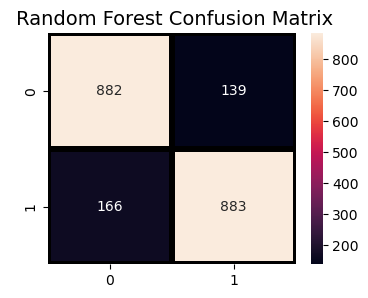

In [39]:
# Confusion matrices
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, rfc_preds), annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title(" Random Forest Confusion Matrix",fontsize=14)
plt.show()

In [40]:
# Classification reports
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, rfc_preds))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1021
           1       0.86      0.84      0.85      1049

    accuracy                           0.85      2070
   macro avg       0.85      0.85      0.85      2070
weighted avg       0.85      0.85      0.85      2070



In [41]:
# AUC-ROC scores
rfc_auc = roc_auc_score(y_test, rfc_probs)

print(f"Logistic Regression AUC: {rfc_auc:.4f}")

Logistic Regression AUC: 0.9280


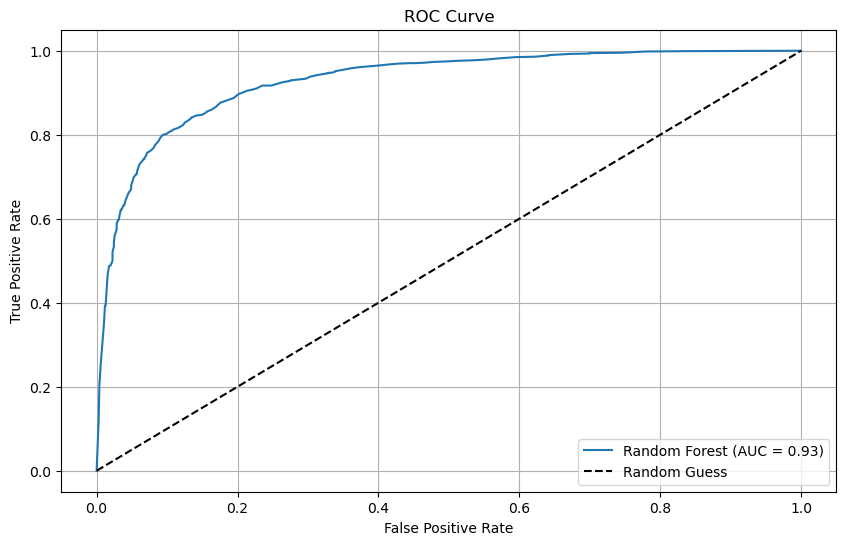

In [42]:
# ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, rfc_probs)

plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Random Forest (AUC = {rfc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.savefig('roc_curve.png', bbox_inches='tight', dpi = 300)
plt.show()